In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np

# Some useful utilities

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def z_clip(xs, b):
    return [min(x, b) for x in xs]

def clip(xs, upper, lower):
    return [max(min(x, upper), lower) for x in xs]

def your_code_here():
    return 1

def test(msg, value, expected):
    if value == expected:
        print(f"{msg}: {value}, as expected")
    else:
        print(f"{msg}: OH NO! Got {value}, but expected {expected}.")

In [3]:
adult_data = pd.read_csv("adult_with_pii.csv", parse_dates=['DOB'])

## Question 1 (10 points)

Implement a function `rand_resp_over_40` that uses randomized response to answer the question "how many people have ages greater than 40?" 

In [4]:
def aggregate_rr(responses):
    fake_yesses = len(responses)/4
    num_yesses = np.sum([1 if r else 0 for r in responses])
    true_yesses = num_yesses - fake_yesses
    rr_result = true_yesses*2
    return rr_result

def rand_resp_over_40(response):
    
    # Reference to truthful response
    correct_response = response > 40
    
    # Determine the randomized response coinflip
    if np.random.randint(0, 2):
        return correct_response
    else:
        return np.random.randint(0, 2) == 0

aggregate_rr([rand_resp_over_40(r) for r in adult_data['Age']])

13315.5

## Question 2 (30 points)

Implement three functions which together use the unary encoding technique to provide a histogram of ages in the US Census dataset. Your solution should consider ages between 0 and 100, and each histogram bin should have a width of 5 years (i.e. a count for `0 <= age < 5`, `5 <= age < 10`, `10 <= age < 15`, and so on).

In [5]:
# Domain of unary encodings
domain = [x for x in range(0, 100, 5)]

# Probabilities for 'perturb' functions
p = .75
q = .25

In [6]:
def encode_unary_age(response):
    return [1 if x <= response and response <x+5 else 0 for x in domain]

print(encode_unary_age(0))
print(encode_unary_age(1))
print(encode_unary_age(13))
print(encode_unary_age(19))
print(encode_unary_age(20))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
def perturb(bit):
    
    # Sample random float between 0 and 1
    rand_sample = np.random.random()
    
    # Perturb 'bit'
    if bit == 1:
        if rand_sample <= p:
            return 1
        else:
            return 0
    elif bit == 0:
        if rand_sample <= q:
            return 1
        else: 
            return 0

def perturb_unary_age(encoded_response):
    # Perturb each response in 'encoded_response'
    return [perturb(response) for response in encoded_response]
    

perturb_unary_age(encode_unary_age(19))

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

In [8]:
def aggregate_unary_age(responses):
    
    # Reconstruct perturbed responses
    sums = np.sum(responses, axis=0)
    n = len(responses)    
    return [(s - n*q) / (p - q) for s in sums]

0 - 5: -108.5
5 - 10: -34.5
10 - 15: -54.5
15 - 20: 1453.5
20 - 25: 3799.5
25 - 30: 4329.5
30 - 35: 4345.5
35 - 40: 4255.5
40 - 45: 3879.5
45 - 50: 3137.5
50 - 55: 2665.5
55 - 60: 2011.5
60 - 65: 1305.5
65 - 70: 1009.5
70 - 75: 333.5
75 - 80: 183.5
80 - 85: 105.5
85 - 90: -106.5
90 - 95: -124.5
95 - 100: 159.5


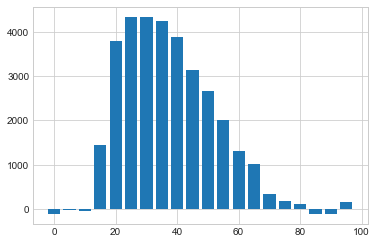

In [9]:
def print_response_unary_age(responses):
    domain = range(0, 100, 5)
    counts = aggregate_unary_age(responses)

    for d, c in zip(domain, counts):
        print('{} - {}: {}'.format(d, d+5, c))
    
    plt.bar(domain, counts, width=4);

responses = [perturb_unary_age(encode_unary_age(r)) for r in adult_data['Age']]
print_response_unary_age(responses)

## Question 3 (30 points)

Consider the `fnlwgt` column of our dataset. This column contains continuous data (not categorical data), with an interesting underlying distribution:

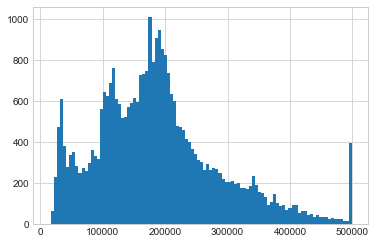

In [10]:
plt.hist(adult_data['fnlwgt'].clip(lower=0, upper=500000), bins=100);

Write code to generate a synthetic representation of this data. Your representation should be a histogram over the range from 0 to 500,000, with a bin width of 5000. You can use the `range_query` function, defined below, to help generate the required counts.

In [11]:
def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (df[col] < b)])

In [12]:
def gen_synthetic_data(epsilon):
    bin_size = 5000
    bins = range(0, 500000, bin_size)
    syn_data = [range_query(adult_data, 'fnlwgt', b, b+bin_size) for b in bins]
    dp_syn_data = [laplace_mech(count, 1, epsilon) for count in syn_data]
    return dp_syn_data

syn_data = gen_synthetic_data(1.0)

## Question 4 (30 points)

Using your synthetic data from the last question, generate tabular data with 5000 synthetic data points. Keep in mind that the `fnlwgt` column contains continuous data, and your synthetic tabular data should too.

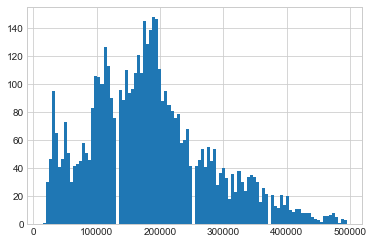

In [13]:
def gen_sample(syn_data):

    # Define constants
    bin_size = 5000
    bins = range(0, 500000, bin_size)
    
    # Normalize synthetic data
    syn_data_nonneg = np.clip(syn_data, 0, None)
    syn_data_normalized = syn_data_nonneg / np.sum(syn_data_nonneg)
    
    return np.random.choice(bins, 1, p=syn_data_normalized)[0]

samples = [gen_sample(syn_data) for i in range(5000)]
plt.hist(samples, bins=100);